# K-means clustering on subsets of the data

## Preparation

In [2]:
import pandas as pd
import pickle as pkl
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from random import seed
from random import randint

In [22]:
seed(1)

### Import GO data

In [3]:
with open('../processed_data/geneOntologyDataset.pkl', 'rb') as inp:
    [pivoted, tfidfPivoted] = pkl.load(inp)

In [4]:
GOdata = pd.DataFrame(tfidfPivoted['C'].todense()) # F / P / C
GOdata['Standard Name'] = pivoted['C'].index

### Import FI data

In [5]:
FIdata = pd.read_excel('../raw_data/41592_2018_45_MOESM4_ESM.xlsx', skiprows = 6, engine = 'openpyxl')
full_data = pd.merge(GOdata, FIdata, on = 'Standard Name', how = 'left')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
full_data = full_data.loc[full_data.intensity.notna()]

In [25]:
selection = full_data.iloc[:,0:full_data.columns.get_loc('intensity')+1]
selection = selection.drop('Systematic Name', axis = 1).drop('Standard Name', axis = 1)

In [26]:
selection

,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,800,801,802,intensity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.092609e-01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.112094e-03
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.613757e-04
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.173913e-03
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.156482e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.722488e-02
4337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.567944e-02
4338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.791119e-01
4339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.071505e+00


### Filter data

In [48]:
full_data = full_data.sort_values('intensity')

In [49]:
random = np.ones(100)
for i in range(100):
    random[i] = randint(100, len(full_data)-100)

In [102]:
top = full_data.iloc[0:100, :]
middle = full_data.iloc[random, :]
bottom = full_data.iloc[-100:, :]
full = pd.concat([top, middle, bottom])

## PCA

In [103]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(full.iloc[:,0:full.columns.get_loc('Standard Name')])
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

Text(0, 0.5, 'Second principal component')

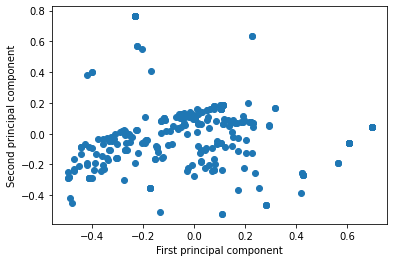

In [104]:
fig, ax = plt.subplots()
ax.scatter(principalDf.PC1, principalDf.PC2)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")

In [105]:
pca.explained_variance_ratio_

array([0.10271766, 0.06167451])

In [106]:
full = full.set_index(principalDf.index)

## K-means clustering

In [107]:
# generate cluster centers and labels
centers, _ = kmeans(principalDf, 5)
principalDf['labels'], _ = vq(principalDf, centers)

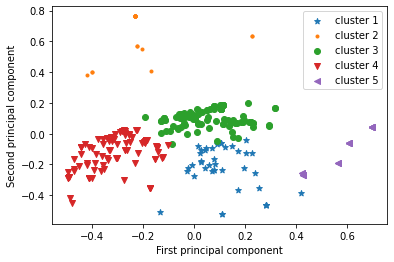

In [108]:
fig, ax = plt.subplots()
ax.scatter(principalDf.PC1[principalDf.labels == 0], principalDf.PC2[principalDf.labels == 0], marker = '*', label = 'cluster 1')
ax.scatter(principalDf.PC1[principalDf.labels == 1], principalDf.PC2[principalDf.labels == 1], marker = '.', label = 'cluster 2')
ax.scatter(principalDf.PC1[principalDf.labels == 2], principalDf.PC2[principalDf.labels == 2], marker = 'o', label = 'cluster 3')
ax.scatter(principalDf.PC1[principalDf.labels == 3], principalDf.PC2[principalDf.labels == 3], marker = 'v', label = 'cluster 4')
ax.scatter(principalDf.PC1[principalDf.labels == 4], principalDf.PC2[principalDf.labels == 4], marker = '<', label = 'cluster 5')
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.legend()
plt.show()

## Spectral clustering

### Use nearest neighbors as affinity measure

In [109]:
model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(principalDf)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


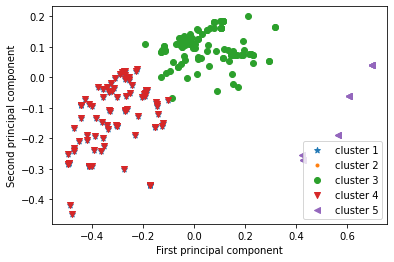

In [110]:
fig, ax = plt.subplots()
ax.scatter(principalDf.PC1[labels == 0], principalDf.PC2[labels == 0], marker = '*', label = 'cluster 1')
ax.scatter(principalDf.PC1[labels == 1], principalDf.PC2[labels == 1], marker = '.', label = 'cluster 2')
ax.scatter(principalDf.PC1[principalDf.labels == 2], principalDf.PC2[principalDf.labels == 2], marker = 'o', label = 'cluster 3')
ax.scatter(principalDf.PC1[principalDf.labels == 3], principalDf.PC2[principalDf.labels == 3], marker = 'v', label = 'cluster 4')
ax.scatter(principalDf.PC1[principalDf.labels == 4], principalDf.PC2[principalDf.labels == 4], marker = '<', label = 'cluster 5')
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.legend()
plt.show()

### Use rbf as affinity measure

In [111]:
model = SpectralClustering(n_clusters=2, affinity='rbf',
                           assign_labels='kmeans')
labels = model.fit_predict(principalDf)

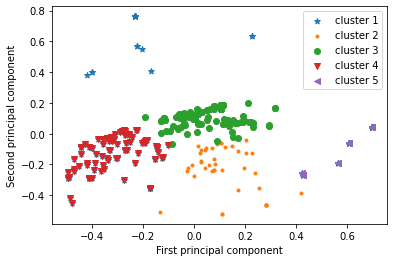

In [112]:
fig, ax = plt.subplots()
ax.scatter(principalDf.PC1[labels == 0], principalDf.PC2[labels == 0], marker = '*', label = 'cluster 1')
ax.scatter(principalDf.PC1[labels == 1], principalDf.PC2[labels == 1], marker = '.', label = 'cluster 2')
ax.scatter(principalDf.PC1[principalDf.labels == 2], principalDf.PC2[principalDf.labels == 2], marker = 'o', label = 'cluster 3')
ax.scatter(principalDf.PC1[principalDf.labels == 3], principalDf.PC2[principalDf.labels == 3], marker = 'v', label = 'cluster 4')
ax.scatter(principalDf.PC1[principalDf.labels == 4], principalDf.PC2[principalDf.labels == 4], marker = '<', label = 'cluster 5')
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.legend()
plt.show()

### plot FI in PC plot

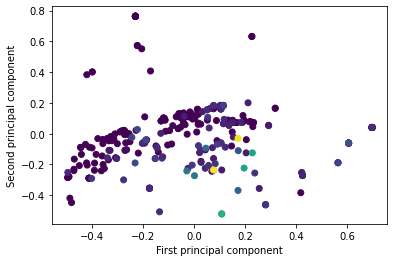

In [113]:
fig, ax = plt.subplots()
ax.scatter(principalDf.PC1, principalDf.PC2, c = full.intensity)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
plt.show()

In [114]:
full_data.intensity.max()

34.7025481019241

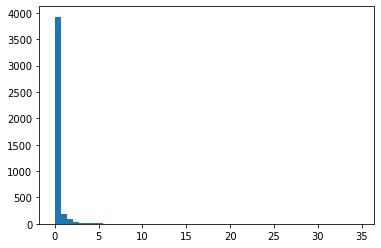

In [115]:
fig, ax = plt.subplots()
ax.hist(full_data.intensity, bins = 50)
plt.show()

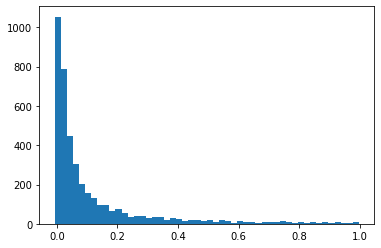

In [116]:
fig, ax = plt.subplots()
ax.hist(full_data.intensity[full_data.intensity < 1], bins = 50)
plt.show()